<a href="https://colab.research.google.com/github/aanya-v/347_project/blob/main/Calories_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import time
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Cleanup

In [3]:
df = pd.read_csv('calories.csv')
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [4]:
df = pd.read_csv('calories.csv')
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df.drop(['User_ID'], axis=1, inplace=True)
df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,1,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,1,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,1,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,0,78,193.0,97.0,2.0,84.0,38.3,11.0


# Neural Network



In [39]:
#@title Helper Functions
from matplotlib import animation, rc
rc('animation', html='jshtml')
from IPython.display import HTML
from keras.callbacks import Callback
import matplotlib.gridspec as gridspec

class SaveWeights(Callback):
    def __init__(self, interval=1):
        self.interval = interval

    def on_train_begin(self, logs=None):
        self.weights = []
        self.weights.append([w.numpy()+w.numpy().min() for w in self.model.weights if 'bias' not in w.name])

    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.interval == 0:
            self.weights.append([w.numpy()+w.numpy().min() for w in self.model.weights if 'bias' not in w.name])

    def on_train_end(self, batch, logs=None):
        n_Weights = len(self.weights[0])
        fig, axes = plt.subplots(1, n_Weights, figsize=(1.5*n_Weights,5))
        axes = axes.flatten()
        ims = []
        for i in range(n_Weights):
            ax = axes[i]
            ax.set_title(r'$W_%i$'%(i+1))

        for t in range(len(self.weights)):
            ims_t = []
            for i in range(n_Weights):
                ax = axes[i]
                weights = self.weights[t]
                w = weights[i]
                w = np.atleast_2d(w)
                if w.shape[1] == 1:
                    w = w.T
                im = ax.imshow(w, cmap='Greys', animated=True)
                ims_t.append(im)
            ims.append(ims_t)
        self.anim = animation.ArtistAnimation(fig, ims, interval=33, blit=True,
                                              repeat_delay=1000)
        pass
    def animate(self):
      return self.anim


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")
    if 'val_mae' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['mae'], '--', label='Training Inaccuracy (via MAE)', color='firebrick', )
        ax2.plot(hist.history['val_mae'], '--', label='Testing Inaccuracy (via MAE)', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("mean absolute error")
weights_list = SaveWeights()

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [8]:
X = df.drop(['Calories'], axis=1)
y = df['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Define the model
model = keras.Sequential([
    Dense(7, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 7 neurons
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(16, activation='relu'), # Hidden layer with 16 neurons
    Dense(1)  # Output layer (no activation function is used for regression!)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Use mean squared error for regression

# Train the model
calories_ann = model.fit(X_train, y_train, epochs=50, batch_size=200, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error: {mae}")


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4750.9619 - mae: 54.7942 - val_loss: 3100.7708 - val_mae: 47.6468
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2670.6863 - mae: 43.9244 - val_loss: 1601.1448 - val_mae: 33.5170
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1085.5096 - mae: 26.7843 - val_loss: 268.8647 - val_mae: 11.5268
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196.5599 - mae: 9.9075 - val_loss: 129.9088 - val_mae: 8.5577
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 116.5555 - mae: 7.9917 - val_loss: 105.8049 - val_mae: 7.6374
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.9323 - mae: 7.6121 - val_loss: 103.8085 - val_mae: 7.4746
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101.9317 - mae: 7.5702 - val_loss: 98.0922 - val_mae: 7.5319
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.9104 - mae: 7.3289 - val_loss: 89.5400 - val_mae: 7.0993
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━

**Plotting training history to evaluate if model trained properly** (bc its confusing to look at all the numbers lol, this uses the helper function at the start!)

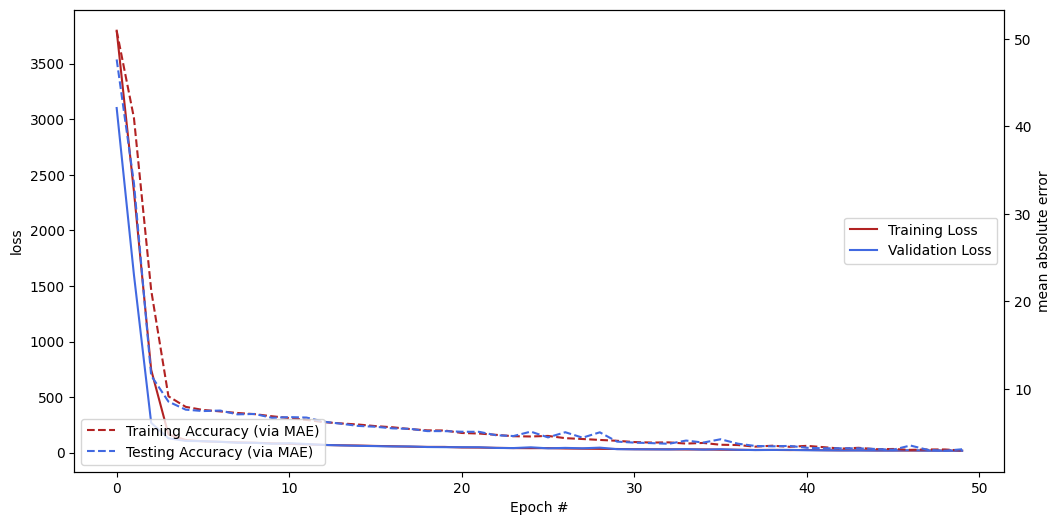

In [38]:
plot_training_history(calories_ann)

**Evaluate Predictions**

In [54]:
# Make predictions from our model
calories_pred = model.predict(X_test)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [55]:
# Calculate accuracy (example using R-squared)
r2 = r2_score(y_test, calories_pred)
print(f"R-squared (R2) Accuracy: {r2}")

R-squared (R2) Accuracy: 0.9954612978538172


In [59]:
mse = mean_squared_error(y_test, calories_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 18.317255439719048
